# IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import optuna

# GETTING THE DATA

In [2]:
df = pd.read_csv('customer_booking.csv', encoding='ISO-8859-9')

# PERFORMING BASIC CHECKS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [5]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [6]:
df.duplicated().sum()

719

# CONVERTING CAT COLUMNS TO INTEGER

In [7]:
cat_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# DEFINING FEATURES AND TARGET

In [8]:
x = df.drop(columns=['booking_complete'])
y = df['booking_complete']

In [9]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled, = smote.fit_resample(x,y)

# SPLITTING THE DATASET

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled,y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# SCALING NUM FEATURES

In [11]:
scaler = StandardScaler()
num_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
x_train[num_features] = scaler.fit_transform(x_train[num_features])
x_test[num_features] = scaler.transform(x_test[num_features])

# HYPERPARAMETER TUNING FOR LOGISTIC REGRESSION

In [12]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train, y_train)
best_log_reg = grid_search.best_estimator_

# TRAINING BEST LOGISTIC REGRESSION

In [13]:
best_log_reg.fit(x_train, y_train)
log_reg_pred = best_log_reg.predict(x_test)
log_reg_proba = best_log_reg.predict_proba(x_test)[:, 1]

In [14]:
best_log_reg

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42)

In [15]:
log_reg_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

# CROSS-VALIDATION FOR LOGISTIC REGRESSION

In [18]:
log_reg_cv = cross_val_score(best_log_reg, x_train, y_train, cv=5, scoring='roc_auc')

In [19]:
print("Logistic Regression Cross-Validation AUC Scores:", log_reg_cv)
print("Mean AUC Score:", np.mean(log_reg_cv))

Logistic Regression Cross-Validation AUC Scores: [0.69762701 0.69801495 0.68818532 0.70230823 0.69192807]
Mean AUC Score: 0.6956127159897556


# Hyperparameter Tuning for XGBoost using Optuna

In [20]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    }
    model = XGBClassifier(eval_metric='logloss', random_state=42, **params)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

# TRAINING XGBOOST CLASSIFIER

In [21]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)
xgb_proba = xgb_model.predict_proba(x_test)[:, 1]

# CROSS_VALIDATION FOR XGBOOST

In [22]:
xgb_cv = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='roc_auc')
print("XGBoost Cross-Validation AUC Scores:", xgb_cv)
print("Mean AUC Score:", np.mean(xgb_cv))

XGBoost Cross-Validation AUC Scores: [0.92093291 0.92393777 0.91984447 0.92426766 0.91989345]
Mean AUC Score: 0.9217752516591264


# MODEL EVALUATION

In [23]:
print("Logistic Regression Performance:")
print(classification_report(y_test, log_reg_pred))
print("ROC AUC Score:", roc_auc_score(y_test, log_reg_proba))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.67      0.60      0.64      8505
           1       0.64      0.71      0.67      8504

    accuracy                           0.65     17009
   macro avg       0.66      0.65      0.65     17009
weighted avg       0.66      0.65      0.65     17009

ROC AUC Score: 0.700908836758633


In [24]:
print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_proba))


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      8505
           1       0.83      0.85      0.84      8504

    accuracy                           0.84     17009
   macro avg       0.84      0.84      0.84     17009
weighted avg       0.84      0.84      0.84     17009

ROC AUC Score: 0.922588312005057


# VISUALIZING XGBOOST

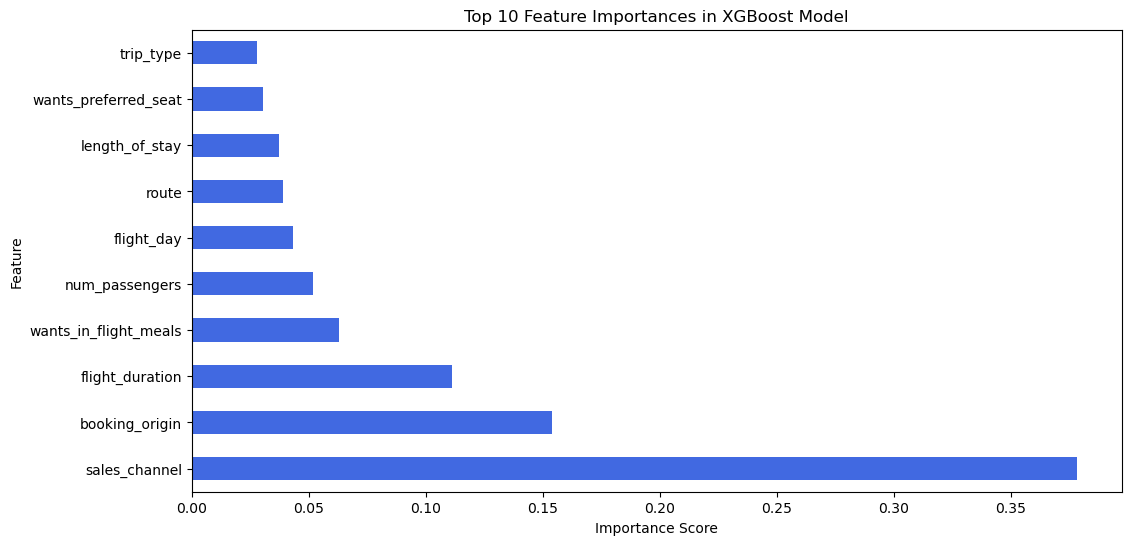

In [25]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=x.columns)
plt.figure(figsize=(12, 6))
feature_importances.nlargest(10).plot(kind='barh', color='royalblue')
plt.title("Top 10 Feature Importances in XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# PLOTTING THE CONFUSION MATRICES

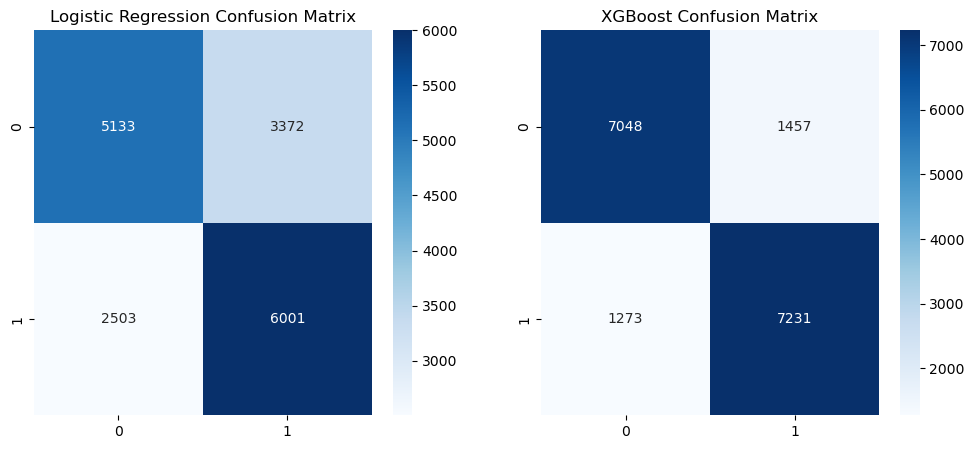

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, log_reg_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
plt.show()